In [1]:
import torch

/opt/anaconda3/envs/torch8019/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable



In [ ]:
ss = pd.read_csv("21ss.csv",encoding='utf-8')
print(ss.head())
print(ss.describe())

In [ ]:
aw = pd.read_csv("20aw.csv",encoding='utf-8')
print(aw.head())
print(aw.describe())

In [ ]:
aw = pd.read_table("20aw.csv",sep=',')
print(aw.head())
print(aw.describe())
print(aw.info())

In [ ]:
aw_ss = pd.concat([aw,ss],axis=0)
aw_ss = aw_ss.reset_index(drop=True)
aw_ss

In [ ]:
aw_ss.to_csv("all_sample.csv",encoding='utf-8')

In [3]:
#把wrong變成no_fit 因為wrong也算是no_fit
all_sample=pd.read_csv("all_sample.csv",index_col=0)
all_sample['ans'] = all_sample['ans'].str.replace("wrong","not_fit")
all_sample

,head_label,tail_label,head_name,tail_name,ans
0,AB12289,BA6034,純色翻領壓褶貝殼排扣荷葉七分袖/短袖上衣,純色高含棉坑條燈芯絨腰鬆緊五分短寬褲,fit
1,AB12289,CA2163,純色翻領壓褶貝殼排扣荷葉七分袖/短袖上衣,優雅蕾絲不易皺後腰鬆緊斜開岔短裙,fit
2,AB12289,BA5836,純色翻領壓褶貝殼排扣荷葉七分袖/短袖上衣,柔軟質感天絲棉丹寧落地大寬褲,fit
3,AB12289,BA5840,純色翻領壓褶貝殼排扣荷葉七分袖/短袖上衣,簡約知性立挺打褶造型西裝短褲．附質感皮帶,fit
4,AB12289,BA5861,純色翻領壓褶貝殼排扣荷葉七分袖/短袖上衣,休閒彈力英字印花窄管緊身長褲內搭褲,not_fit
...,...,...,...,...,...
9995,KS0843,BA6277,下襬抽皺透氣吸濕無袖上衣/背心,滿版碎花吊帶連身寬版長褲,fit
9996,KS0843,BA6237,下襬抽皺透氣吸濕無袖上衣/背心,修身剪裁打褶不易皺直筒西裝褲,fit
9997,KS0843,BA6256,下襬抽皺透氣吸濕無袖上衣/背心,純色高含棉鬆緊腰抽皺口袋寬褲裙,fit
9998,KS0843,KS0819,下襬抽皺透氣吸濕無袖上衣/背心,造型褲口休閒長褲/運動長褲,fit


In [4]:
#fit 7015,no_fit 2181, wrong 804
#all_sample=pd.read_csv("all_sample.csv")

negative_data=all_sample[all_sample["ans"]=="not_fit"]
postive_data=all_sample[all_sample["ans"]=="fit"]


#訓練80% 測試20%
train_P=postive_data.sample(7015,random_state=178)#訓練5615 測試1400
train_N=negative_data.sample(2985,random_state=198)#訓練2410 測試575
test_P=train_P.sample(1400,random_state=73)
test_N=train_N.sample(575,random_state=65)

train_P=train_P.drop(test_P.index)
train_N=train_N.drop(test_N.index)
#source上身代碼#下身代碼
train_P=train_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
train_N=train_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_P=test_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_N=test_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)

In [5]:
#transform可以旋轉 縮放
transform=transforms.Compose([
    transforms.Resize(224), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.CenterCrop([150,224]), #中心裁剪，从中间切出 150*224的图片
])


In [ ]:
#把秋冬跟春夏資料及底下的子資料夾所有圖片都放在一起(會有重複的圖片)
#順便把圖片名稱改成單純編號
os.mkdir("OB_imgs")
save_dir = "OB_imgs/"
aw_dir = os.listdir("20aw/fit")
ss_dir = os.listdir("21ss/fit")
aw_label = aw[['head_label','tail_label']]
ss_label = ss[['head_label','tail_label']]
t_rec = []
b_rec = []

for i,fit in enumerate(tqdm(aw_dir)):
    path = "20aw/fit/" + fit
    fit_list = os.listdir(path)
    t = aw_label.iloc[i][0]
    b = aw_label.iloc[i][1]
    if fit_list[0].startswith(t):
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
    elif fit_list[0].startswith(b):
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
    
for j,fit in enumerate(tqdm(ss_dir)):
    path = "21ss/fit/" + fit
    fit_list = os.listdir(path)
    t = ss_label.iloc[j][0]
    b = ss_label.iloc[j][1]
    if fit_list[0].startswith(t):
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
    elif fit_list[0].startswith(b):
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
    
    
    

In [9]:
imgs=os.listdir("OB_imgs")#回傳該路徑下有哪些檔案
pbar=tqdm(total=len(imgs))
for img in imgs:
    path="OB_imgs/"+img
    pil_img=Image.open(path)
    ttt=transform(pil_img)
    save_dir="crop_img_test/"+img
    ttt.save(save_dir)
    pbar.update(1)

pbar.close()
    

100%|██████████| 1579/1579 [00:45<00:00, 34.83it/s]


In [10]:
def v_merge_img(data_df):
    source=list(data_df["head_label"])
    target=list(data_df["tail_label"])
    type=list(data_df["ans"])[0]
    if(len(data_df)==5615 and type=="fit"):
        folder_name="train/fit"
    elif(len(data_df)==2410 and type=="not_fit"):
        folder_name="train/not_fit"
    elif(len(data_df)==1400 and type=="fit"):
        folder_name="test/fit"
    elif(len(data_df)==575 and type=="not_fit"):
        folder_name="test/not_fit"

    if (os.path.exists(folder_name)==False):
        os.mkdir(folder_name)

    for i,top in enumerate(source):
        top_dir="crop_img_test/"+top+".png"
        bottom_dir="crop_img_test/"+target[i]+".png"
        #用opencv讀取圖片
        top_img = cv2.imread(top_dir)
        bottom_img = cv2.imread(bottom_dir)
        fit_img = np.vstack([top_img, bottom_img])  # 垂直拼接，變成上下兩個組圖

        fit_img_dir=folder_name+"/fit"+str(i)+".png"
        cv2.imwrite(fit_img_dir,fit_img)
        
   


In [12]:
v_merge_img(test_P)
v_merge_img(test_N)

v_merge_img(train_P)
v_merge_img(train_N)


In [5]:
transform2=transforms.Compose([#compose可以把調整方法串接起來
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素, VGG的輸入規定格式
    transforms.ToTensor(), #將圖片或是ndarray轉換成Tensor,除255歸一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #標準化至[-1,1]其實並非到0~1之間，模型才容易收斂 mean變成0 std變成1
])

batch_size=64 #原本16，建議設2的n次方，較有效率

train_dir = "train"           
#定義數據集
train_datasets = datasets.ImageFolder(train_dir, transform=transform2)
#加載數據集
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [19]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=False)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),#原num_classes 因BCE input只能1
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [20]:
print(VGGNet())

VGGNet(
  (features): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [7]:
# #Focal Loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=.25, gamma=2):
#             super(FocalLoss, self).__init__()        
#             self.alpha = torch.tensor([alpha, 1-alpha]).cuda()        
#             self.gamma = gamma
            
#     def forward(self, output, label):
#             output_sq = output.squeeze(1)
#             BCE_loss = F.binary_cross_entropy_with_logits(output_sq, label.float(), reduction='none')        
#             #label = label.type(torch.long)        
#             at = self.alpha.gather(0, label.data.view(-1))        
#             pt = torch.exp(-BCE_loss)        
#             F_loss = at*(1-pt)**self.gamma * BCE_loss        
#             return F_loss.mean()

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.tensor(alpha)
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = (1 - pt) ** self.gamma * CE_loss

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            focal_loss = self.alpha[targets] * focal_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [ ]:
#釋放無用的內存
#if hasattr(torch.cuda,'empty_cache'):
#torch.cuda.empty_cache()

In [8]:
learning_rate = 5e-5#5的負5次方
epoch = 20#如果overfitting的話，可以找train跟test都在高峰的epoch，就不要那麼多次epoch

model = VGGNet()
if torch.cuda.is_available():
    model.cuda()
params = [{'params': md.parameters()} for md in model.children()
          if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#loss_func = nn.CrossEntropyLoss()#可以改成focal loss 更多注意在負樣本
loss_func = FocalLoss()

model.train()

loss_list = []
accuracy_list = []
tr_loss_list = []
tr_accuracy_list = []

for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    pbar=tqdm(total=len(train_dataloader))
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()

    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_datasets)), train_acc / (len(train_datasets))))
    tr_loss_list.append(train_loss / (len(train_datasets)))
    tr_accuracy_list.append(100 * train_acc / (len(train_datasets)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    #混淆矩陣要用得list
    y_true=[]
    y_pred=[]
    for img, label in val_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = model(img)
        loss = loss_func(out, label)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
        #混淆矩陣
        y_true.extend(label.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))
    loss_list.append(eval_loss / (len(val_datasets)))
    accuracy_list.append(100 * eval_acc / (len(val_datasets)))

c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch 1


100%|██████████| 126/126 [01:29<00:00,  1.40it/s]


Train Loss: 0.001076, Acc: 0.327850
Test Loss: 0.001065, Acc: 0.291139
epoch 2


100%|██████████| 126/126 [01:28<00:00,  1.43it/s]


Train Loss: 0.001072, Acc: 0.305171
Test Loss: 0.001069, Acc: 0.291139
epoch 3


100%|██████████| 126/126 [01:27<00:00,  1.44it/s]


Train Loss: 0.001063, Acc: 0.383302
Test Loss: 0.001023, Acc: 0.508861
epoch 4


100%|██████████| 126/126 [01:27<00:00,  1.44it/s]


Train Loss: 0.001038, Acc: 0.498193
Test Loss: 0.000991, Acc: 0.600506
epoch 5


100%|██████████| 126/126 [01:23<00:00,  1.52it/s]


Train Loss: 0.000971, Acc: 0.615202
Test Loss: 0.000915, Acc: 0.657722
epoch 6


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000905, Acc: 0.647726
Test Loss: 0.000881, Acc: 0.683038
epoch 7


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000815, Acc: 0.719502
Test Loss: 0.000837, Acc: 0.685063
epoch 8


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000714, Acc: 0.768349
Test Loss: 0.000706, Acc: 0.757468
epoch 9


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000607, Acc: 0.816075
Test Loss: 0.000726, Acc: 0.818228
epoch 10


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000515, Acc: 0.848349
Test Loss: 0.000661, Acc: 0.824810
epoch 11


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000449, Acc: 0.868660
Test Loss: 0.000733, Acc: 0.795949
epoch 12


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000376, Acc: 0.889969
Test Loss: 0.000744, Acc: 0.840000
epoch 13


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000321, Acc: 0.909907
Test Loss: 0.000757, Acc: 0.783797
epoch 14


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000283, Acc: 0.920249
Test Loss: 0.000883, Acc: 0.832911
epoch 15


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000244, Acc: 0.932461
Test Loss: 0.001068, Acc: 0.845063
epoch 16


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000196, Acc: 0.945670
Test Loss: 0.001097, Acc: 0.844557
epoch 17


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000166, Acc: 0.955888
Test Loss: 0.001117, Acc: 0.845063
epoch 18


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000151, Acc: 0.961371
Test Loss: 0.001535, Acc: 0.835949
epoch 19


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000091, Acc: 0.977695
Test Loss: 0.001624, Acc: 0.849114
epoch 20


100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Train Loss: 0.000097, Acc: 0.976698
Test Loss: 0.001610, Acc: 0.836456


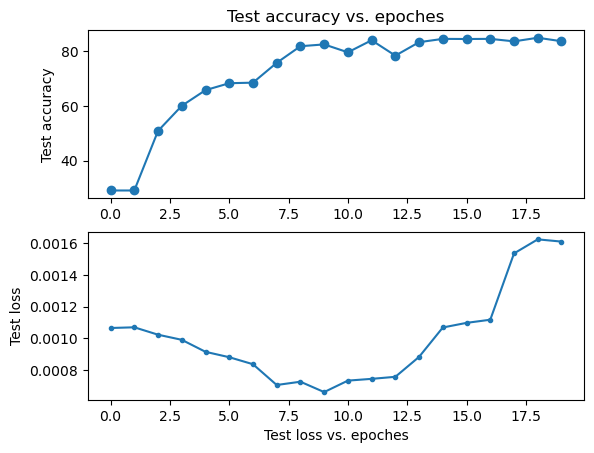

In [9]:
import matplotlib.pyplot as plt

x1 = range(0, 20)
x2 = range(0, 20)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


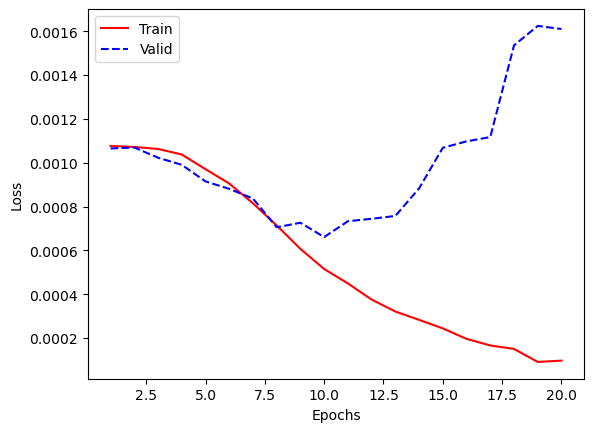

In [10]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(20)]
plt.plot(epochs,tr_loss_list, color='red', label='Train')
plt.plot(epochs,loss_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

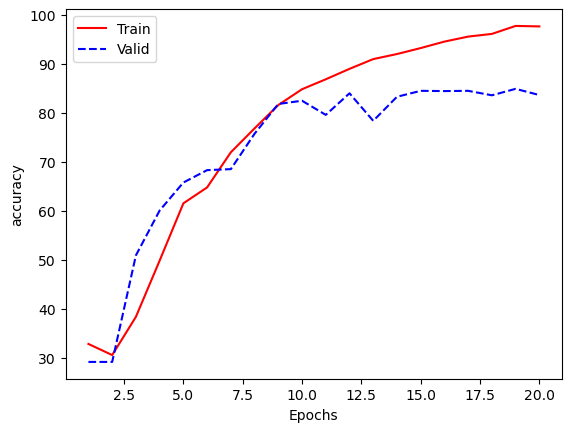

In [11]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(20)]
plt.plot(epochs,tr_accuracy_list, color='red', label='Train')
plt.plot(epochs,accuracy_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

In [11]:
torch.save(model.state_dict(), "VGG16_focal_97_83.pt")


In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

In [13]:
cm

array([[18938,  9062],
       [ 1945,  9555]], dtype=int64)

In [14]:

tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("Accuracy:",(tp+tn)/(tp+fn+fp+tn) )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 0.7213417721518988
FIT precision: 0.9068620408945075
FIT recall: 0.6763571428571429
n_FIT precision: 0.5132405865606704
n_FIT recall: 0.8308695652173913
F1 0.7748296953951271


[0.         0.32364286 1.        ] [0.         0.83086957 1.        ] [2 1 0]


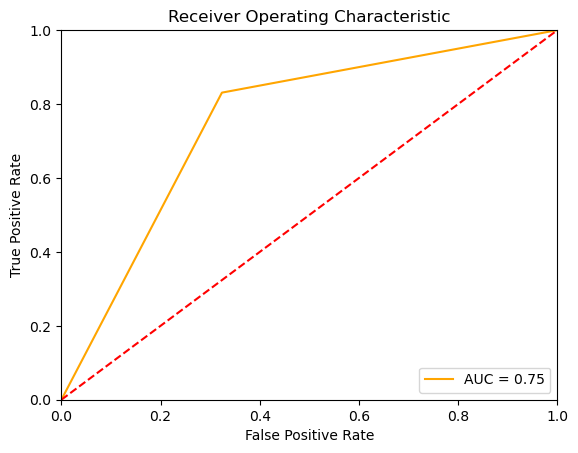

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    